In [24]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as web
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
df5183 = web.DataReader('5183.KL', data_source='yahoo', start='2011-03-12',end='2020-03-12')

In [3]:
df5183['Difference'] = df5183['Open'] - df5183['Close']
df5183.head()

,High,Low,Open,Close,Volume,Adj Close,Difference
Date,,,,,,,
2011-03-14,6.82,6.47,6.52,6.75,17068200.0,5.005249,-0.23
2011-03-15,6.77,6.56,6.75,6.59,17123100.0,4.886606,0.16
2011-03-16,6.67,6.58,6.62,6.63,13315400.0,4.916266,-0.01
2011-03-17,6.65,6.58,6.63,6.63,7634200.0,4.916266,0.00
2011-03-18,6.71,6.62,6.66,6.70,13221200.0,4.968173,-0.04


In [4]:
df5183.tail()

,High,Low,Open,Close,Volume,Adj Close,Difference
Date,,,,,,,
2020-03-06,5.67,5.52,5.64,5.65,3884700.0,5.566207,-0.01
2020-03-09,5.35,4.40,5.35,4.40,25781200.0,4.334746,0.95
2020-03-10,4.63,4.24,4.30,4.35,15704300.0,4.285487,-0.05
2020-03-11,4.79,4.38,4.45,4.72,13616300.0,4.650000,-0.27
2020-03-12,4.70,4.45,4.54,4.65,10009100.0,4.650000,-0.11


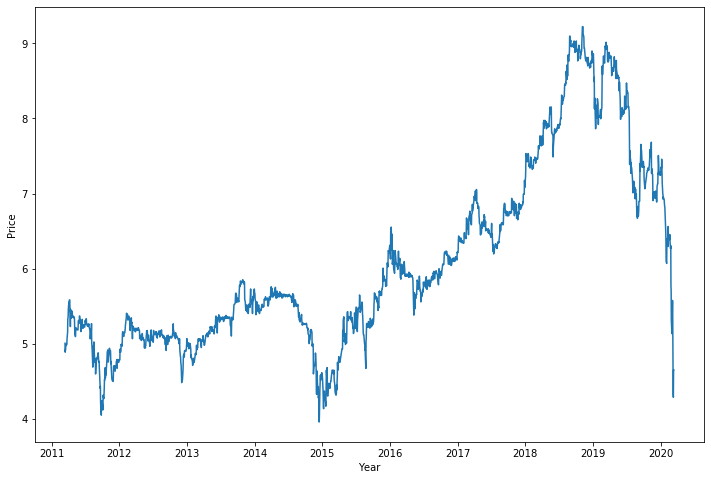

In [5]:
plt.figure(figsize = (12,8))
plt.plot(df5183['Adj Close'])
plt.xlabel("Year")
plt.ylabel("Price")
plt.show()

In [6]:
df5183.to_csv('pchem.csv')

In [7]:
dfPre = []
dfPre = df5183[['Adj Close']]

In [8]:
print(dfPre.head())

            Adj Close
Date                 
2011-03-14   5.005249
2011-03-15   4.886606
2011-03-16   4.916266
2011-03-17   4.916266
2011-03-18   4.968173


In [9]:
forecast_out = 30 #predict n days into the future, in this case, 30
dfPre['Prediction'] = dfPre[['Adj Close']].shift(-forecast_out)
print(dfPre.head())

            Adj Close  Prediction
Date                             
2011-03-14   5.005249    5.376008
2011-03-15   4.886606    5.361178
2011-03-16   4.916266    5.353763
2011-03-17   4.916266    5.346348
2011-03-18   4.968173    5.361178


C:\Users\ADMIN\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
X = np.array(dfPre.drop(['Prediction'], 1))
len(X)

2225

In [11]:
#reserving 60 data for testing
X_new = X[0:2165]
len(X_new) + 60

2225

In [12]:
X_new[0:10]

array([[5.00524902],
       [4.88660622],
       [4.91626644],
       [4.91626644],
       [4.96817255],
       [4.97558975],
       [4.99783373],
       [4.99041843],
       [5.01266384],
       [5.06456995]])

In [13]:
y = np.array(dfPre['Prediction'])
y_new = y[:-60]
len(y_new)

2165

In [14]:
y_new[0:10]

array([5.37600803, 5.36117792, 5.35376263, 5.34634781, 5.36117792,
       5.35376263, 5.32410097, 5.24994993, 5.13130713, 5.09423065])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size = 0.2)

In [16]:
y = np.array(dfPre['Prediction'])
y = y[:-forecast_out]
print(y)
len(y)

[5.37600803 5.36117792 5.35376263 ... 4.28548717 4.64999962 4.6500001 ]


2195

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [18]:
y_pre = lr.predict(X[2195:2225])
print("Predicted last 30 days")
print(y_pre)

Predicted last 30 days
[6.116296   6.08776952 6.35401499 6.34450601 6.4110675  6.36352351
 6.30647101 6.5632075  6.430085   6.4110675  6.4110675  6.45861148
 6.39204999 6.4491025  6.45861148 6.36352351 6.27794499 6.31597999
 5.79299848 5.74545495 5.36510493 5.18443844 5.27001743 5.46019244
 5.61233199 5.60282347 4.41422987 4.36668589 4.71850943 4.71850989]


In [19]:
confidence = lr.score(X_test, y_test)
print("Confidence Score: ", confidence)

Confidence Score:  0.9260544920368285


In [20]:
x_forecast = np.array(dfPre.drop(['Prediction'], 1))[-forecast_out:]
print("Actual last 30 days: ")
print(x_forecast)

Actual last 30 days: 
[[6.09819889]
 [6.06864357]
 [6.34449148]
 [6.33463955]
 [6.40360165]
 [6.35434294]
 [6.29523277]
 [6.56122875]
 [6.42330503]
 [6.40360165]
 [6.40360165]
 [6.45286036]
 [6.38389826]
 [6.44300842]
 [6.45286036]
 [6.35434294]
 [6.26567793]
 [6.30508471]
 [5.76324129]
 [5.71398306]
 [5.31991529]
 [5.13273287]
 [5.22139835]
 [5.41843224]
 [5.57605886]
 [5.56620741]
 [4.33474588]
 [4.28548717]
 [4.64999962]
 [4.6500001 ]]


Text(0, 0.5, 'Price')

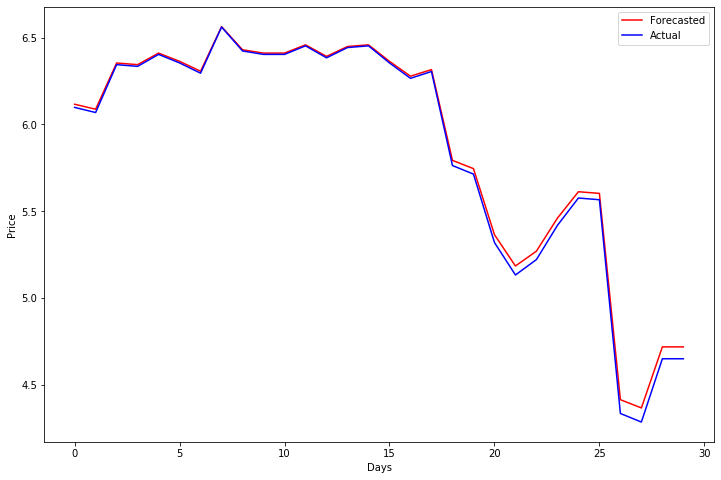

In [21]:
plt.figure(figsize = (12,8))
plt.plot(y_pre, color='r')
plt.plot(x_forecast, color='b')
plt.legend(['Forecasted', 'Actual'])
plt.xlabel("Days")
plt.ylabel("Price")

In [25]:
print("Mean Squared Error: ", metrics.mean_squared_error(y_pre, x_forecast))

Mean Squared Error:  0.0012495369759593377


In [26]:
y_pre2 = [] 
y_pre2.append(np.array(y_pre))
for x in range(11):
    y_pre_alt = y_pre2[x]
    y_pre_in = lr.predict(y_pre_alt.reshape(-1, 1))
    y_pre2.append(np.array(y_pre_in))

In [27]:
forward = []
for x in y_pre2:
    for y in x:
        forward.append(y)

print(y_pre2)
print(forward)

[array([6.116296  , 6.08776952, 6.35401499, 6.34450601, 6.4110675 ,
       6.36352351, 6.30647101, 6.5632075 , 6.430085  , 6.4110675 ,
       6.4110675 , 6.45861148, 6.39204999, 6.4491025 , 6.45861148,
       6.36352351, 6.27794499, 6.31597999, 5.79299848, 5.74545495,
       5.36510493, 5.18443844, 5.27001743, 5.46019244, 5.61233199,
       5.60282347, 4.41422987, 4.36668589, 4.71850943, 4.71850989]), array([6.13376313, 6.10622967, 6.36320698, 6.35402902, 6.41827345,
       6.37238451, 6.31731803, 6.56511737, 6.43662894, 6.41827345,
       6.41827345, 6.4641624 , 6.39991796, 6.45498443, 6.4641624 ,
       6.37238451, 6.28978502, 6.326496  , 5.8217198 , 5.77583129,
       5.40872149, 5.23434411, 5.31694404, 5.50049894, 5.64734242,
       5.6381649 , 4.49094698, 4.44505803, 4.78463438, 4.78463482]), array([6.15062223, 6.12404722, 6.37207899, 6.36322052, 6.42522857,
       6.38093704, 6.32778747, 6.56696076, 6.44294509, 6.42522857,
       6.42522857, 6.46952009, 6.40751204, 6.46066162, 6.

Text(0, 0.5, 'Price')

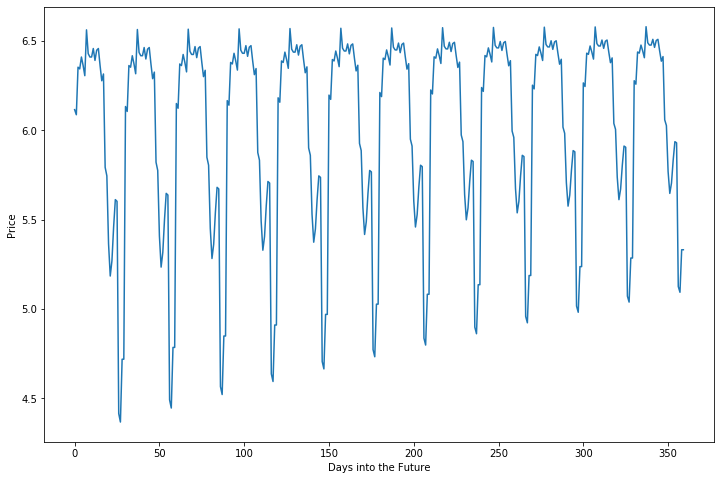

In [28]:
#The stock prices predicted from 1 day into the future, to 365 days into the future
plt.figure(figsize = (12,8))
plt.plot(forward)
plt.xlabel("Days into the Future")
plt.ylabel("Price")